# Deep Learning - Nasir Hussain - 2021/10/16

# 12 Generative deep learning

## 12.3 Neural style transfer

- Neural style transfer consists of applying the style of a reference image to a target image while conserving the content of the target image.
- style essentially means textures, colors, and visual patterns in the image, at various spatial scales, and the content is the higher-level macrostructure of the image
- content and style appropriate loss function

  ```
  loss = (
    distance(style(reference_image) - style(combination_image)) +
    distance(content(original_image) - content(combination_image))
  )
  ```
  - distance is a norm function such as the L2 norm
  - content is a function that takes an image and computes a representation of its content
  - style is a function that takes an image and computes a representation of its style

### 12.3.1 The content loss

- activations from earlier layers in a network contain local information about the image
- activations from higher layers contain increasingly global, abstract information.
- A good candidate for content loss is thus the L2 norm
- seen from the upper layer, the generated image will look similar to the original target image

### 12.3.2 The style loss

- uses multiple layers of a convnet
- style loss aims to preserve similar internal correlations within the activations of different layers, across the style-reference image and the generated image.
- use a pretrained convnet to define a loss
  - Preserve content by maintaining similar high-level layer activations between the original image and the generated image. The convnet should “see” both the original image and the generated image as containing the same things.
  - Preserve style by maintaining similar correlations within activations for both low-level layers and high-level layers. Feature correlations capture textures: the generated image and the style-reference image should share the same textures at different spatial scales.

### 12.3.3 Neural style transfer in Keras

- Set up a network that computes VGG19 layer activations for the style-reference image, the base image, and the generated image at the same time.
- Use the layer activations computed over these three images to define the loss function described earlier, which we’ll minimize in order to achieve style transfer.
- Set up a gradient-descent process to minimize this loss function.

In [1]:
# Listing 12.16 Getting the style and content images
from tensorflow import keras
 
base_image_path = keras.utils.get_file("sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file("starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

958464/943128 [==============================] - 0s 0us/step


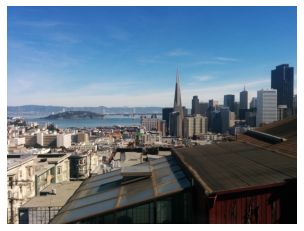

In [2]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

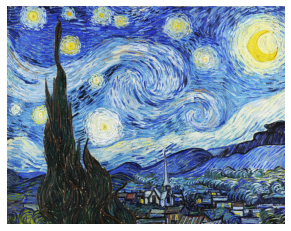

In [3]:
plt.axis("off")
plt.imshow(keras.utils.load_img(style_reference_image_path))

In [4]:
# Listing 12.17 Auxiliary functions
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [5]:
# Listing 12.18 Using a pretrained VGG19 model to create a feature extractor
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80150528/80134624 [==============================] - 1s 0us/step


In [6]:
# Listing 12.19 Content loss
import tensorflow as tf

def content_loss(base_img, combination_img):
  return tf.reduce_sum(tf.square(combination_img - base_img))

In [7]:
# Listing 12.20 Style loss
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [8]:
# Listing 12.21 Total variation loss
def total_variation_loss(x):
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [9]:
# Listing 12.22 Defining the final loss that you’ll minimize
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [11]:
# Listing 12.23 Setting up the gradient-descent process
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 1000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

Iteration 100: loss=8136.83
Iteration 200: loss=6652.36
Iteration 300: loss=6062.83
Iteration 400: loss=5741.71
Iteration 500: loss=5535.33
Iteration 600: loss=5389.94
Iteration 700: loss=5280.56
Iteration 800: loss=5195.01
Iteration 900: loss=5126.07
Iteration 1000: loss=5069.22


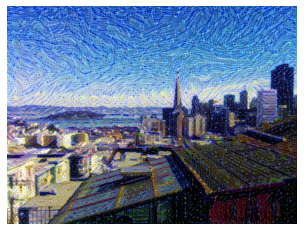

In [12]:
plt.axis("off")
plt.imshow(img)

---